In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from math import radians, sin, cos, sqrt, asin
from sqlalchemy import create_engine
import pymysql
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.use('Agg')

EARTH_RADIUS = 6371.0  # 지구 반지름 km

def haversine(lat1, lon1, lat2, lon2):
    """두 좌표 간 대원거리(km) 계산"""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * EARTH_RADIUS * asin(sqrt(a))

In [2]:

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 2) MySQL 데이터베이스 연결
host = 'localhost'
user = 'root'
password = '0000'
database = 'df_region'
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

# 3) 테이블 불러오기
table_busy = 'busy_table'
df_busy = pd.read_sql(table_busy, con=engine)


In [3]:
df_busy

,시도,시군구,읍면동,시간대,혼잡도,z_score,min_max,fixed_level,quantile_level,final_level,latitude,longitude
0,경기도,가평군,가평읍,00시,408.375000,-0.290630,0.311725,보통,여유,여유,37.825364,127.516539
1,경기도,가평군,가평읍,01시,112.416667,-0.084662,0.498607,보통,보통,보통,37.825364,127.516539
2,경기도,가평군,가평읍,02시,66.208333,0.218280,0.677755,붐빔,붐빔,붐빔,37.825364,127.516539
3,경기도,가평군,가평읍,03시,6.916667,0.070654,0.661022,붐빔,붐빔,붐빔,37.825364,127.516539
4,경기도,가평군,가평읍,04시,-94.708333,0.247461,0.735938,붐빔,붐빔,붐빔,37.825364,127.516539
...,...,...,...,...,...,...,...,...,...,...,...,...
30931,인천광역시,중구,해안동3가,19시,22.041667,-0.182652,0.643921,보통,붐빔,붐빔,37.471410,126.622168
30932,인천광역시,중구,해안동3가,20시,43.750000,-0.034822,0.742341,보통,붐빔,붐빔,37.471410,126.622168
30933,인천광역시,중구,해안동3가,21시,-20.083333,-0.012757,0.770124,보통,매우 붐빔,붐빔,37.471410,126.622168
30934,인천광역시,중구,해안동3가,22시,14.500000,-0.078088,0.738980,보통,붐빔,붐빔,37.471410,126.622168


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class PopularityScorer:
    def __init__(self, review_data):
        """리뷰 데이터 로딩"""
        self.review_data = review_data.copy()
        self.dong_cate_stats = None
        self.scaled_df = None
        self.weights = None

    def calculate_positive_probability(self, row):
        """감정레이블에 따라 긍정확률 계산"""
        if row["감정레이블"] == 2:
            return row["감정확률"]
        elif row["감정레이블"] == 0:
            return 1 - row["감정확률"]
        else:
            return 0.5

    def aggregate_features(self):
        """리뷰수, 평균별점, 평균긍정비율 집계 및 로그리뷰수 추가"""
        self.review_data["긍정확률"] = self.review_data.apply(self.calculate_positive_probability, axis=1)

        stats = self.review_data.groupby(["행정구", "행정동", "카테고리"]).agg(
            리뷰수=("별점", "count"),
            평균별점=("별점", "mean"),
            평균긍정비율=("긍정확률", "mean")
        ).reset_index()

        stats["로그리뷰수"] = np.log1p(stats["리뷰수"])
        self.dong_cate_stats = stats

    def bayesian_adjust(self, value, count, global_mean, m):
        """베이지안 보정"""
        return (count * value + m * global_mean) / (count + m)

    def apply_bayesian_correction(self):
        """평균별점과 평균긍정비율 베이지안 보정"""
        global_avg_rating = self.dong_cate_stats["평균별점"].mean()
        global_avg_posrate = self.dong_cate_stats["평균긍정비율"].mean()
        m_rating = self.dong_cate_stats["리뷰수"].median()
        m_posrate = self.dong_cate_stats["리뷰수"].median()

        self.dong_cate_stats["보정평균별점"] = self.dong_cate_stats.apply(
            lambda row: self.bayesian_adjust(row["평균별점"], row["리뷰수"], global_avg_rating, m_rating), axis=1
        )
        self.dong_cate_stats["보정평균긍정비율"] = self.dong_cate_stats.apply(
            lambda row: self.bayesian_adjust(row["평균긍정비율"], row["리뷰수"], global_avg_posrate, m_posrate), axis=1
        )

    def scale_features(self):
        """MinMaxScaler로 표준화"""
        features = ["로그리뷰수", "보정평균별점", "보정평균긍정비율"]
        scaler = MinMaxScaler()
        self.scaled_df = pd.DataFrame(
            scaler.fit_transform(self.dong_cate_stats[features]),
            columns=features
        )

    def assign_equal_weights(self):
        """단순평균 가중치 부여 (각 1/3)"""
        n_features = self.scaled_df.shape[1]
        self.weights = {col: 1/n_features for col in self.scaled_df.columns}

    def calculate_popularity_score(self):
        """최종 인기도지수 계산"""
        score = sum(
            self.weights[col] * self.scaled_df[col]
            for col in self.scaled_df.columns
        )
        self.dong_cate_stats["인기도지수"] = score

    def run(self):
        """전체 프로세스 실행"""
        self.aggregate_features()
        self.apply_bayesian_correction()
        self.scale_features()
        self.assign_equal_weights()
        self.calculate_popularity_score()
        return self.dong_cate_stats.sort_values(by="인기도지수", ascending=False).reset_index(drop=True)

In [5]:

import pandas as pd

file_review = r"E:\machin-prj\EDA\popularity_fianl\zb_review_data_final.csv"
# 1. 데이터 불러오기
reviews = pd.read_csv(file_review, encoding="utf-8-sig")

# 2. 클래스 인스턴스화
scorer = PopularityScorer(reviews)

# 3. 파이프라인 실행
dong_cate_stats = scorer.run()

# 4. 결과 확인
dong_cate_stats.head(10)

# 5. 결과 저

,행정구,행정동,카테고리,리뷰수,평균별점,평균긍정비율,로그리뷰수,보정평균별점,보정평균긍정비율,인기도지수
0,서울 중구,종로1·2·3·4가동,음식,56,4.732143,0.911946,4.043051,4.536986,0.850754,0.813807
1,서울 마포구,반포4동,음식,40,4.925000,0.936527,3.713572,4.616154,0.850826,0.807700
2,경기 부천시,원종1동,음식,40,4.900000,0.921234,3.713572,4.598913,0.840280,0.794916
3,경기 파주시,교하동,힐링,48,4.875000,0.889881,3.891820,4.617226,0.827290,0.792548
4,서울 강남구,압구정동,문화,82,4.719512,0.839205,4.418841,4.577369,0.807016,0.792465
5,서울 노원구,상계5동,음식,40,4.775000,0.914301,3.713572,4.512706,0.835498,0.779573
6,경기 성남시,단대동,음식,51,4.568627,0.895347,3.951244,4.401984,0.834051,0.776035
7,경기 과천시,문원동,음식,61,4.622951,0.861874,4.127134,4.465024,0.815964,0.773837
8,서울 성북구,명동,음식,35,4.914286,0.907648,3.583519,4.579942,0.823670,0.769535
9,경기 연천군,연천읍,음식,118,4.483051,0.794936,4.779123,4.409830,0.777127,0.759084


In [6]:
df_trip_merged = 'trip_merged'

df_tourism2 = pd.read_sql(df_trip_merged, con=engine)

df_tourism2

,자치구,행정동,힐링,액티비티,문화,음식,쇼핑,숙박,체험다양성_엔트로피,체험다양성_표준편차,위도,경도
0,가평군,가평읍,8.876844,35.535411,8.340898,32.220430,0.889715,0.000000,1.241378,15.629019,37.828841,127.487514
1,가평군,북면,16.513754,39.817658,9.000000,5.884205,0.060781,0.000000,1.137316,15.013705,37.944531,127.494107
2,가평군,상면,6.450964,25.268229,3.985214,17.605723,0.133293,0.000000,1.183715,10.294914,37.790769,127.337749
3,가평군,설악면,8.757376,47.974015,4.162964,28.523809,0.939065,0.000000,1.115577,19.231637,37.653347,127.499130
4,가평군,조종면,2.879345,20.849044,3.314121,16.775161,0.733022,0.058038,1.169467,8.991628,37.867121,127.371755
...,...,...,...,...,...,...,...,...,...,...,...,...
1219,중구,영종1동,1.378579,1.261023,1.519679,4.880436,0.436482,NaN,1.325857,1.721161,37.486842,126.558114
1220,중구,영종2동,1.337295,1.182559,1.417489,4.793340,0.437261,NaN,1.317795,1.699496,37.495635,126.569286
1221,중구,영종동,2.213174,2.429071,1.643989,5.732951,0.347635,NaN,1.352629,1.993813,37.509083,126.534678
1222,중구,용유동,23.811770,11.947058,2.922033,37.514162,0.000000,NaN,1.127921,15.527773,37.433622,126.407745


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pandas.plotting import scatter_matrix

%matplotlib inline


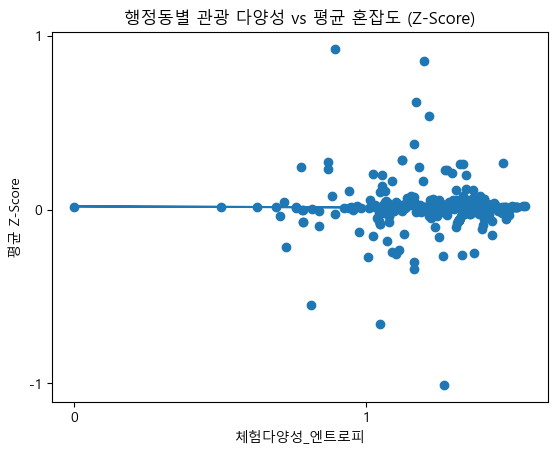

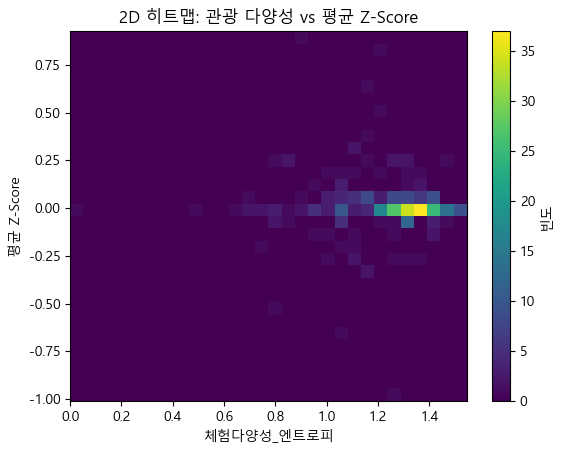

In [8]:
# 1. Prepare aggregated busy data by administrative dong
df_busy['key'] = df_busy['시군구'] + ' ' + df_busy['읍면동']
mapping = {'여유': 1, '보통': 2, '붐빔': 3, '매우 붐빔': 4}
df_busy['final_level_num'] = df_busy['final_level'].map(mapping)
busy_agg = df_busy.groupby('key').agg({
    '혼잡도': 'mean',
    'z_score': 'mean',
    'final_level_num': 'mean'
}).rename(columns={'혼잡도': 'mean_busy', 'z_score': 'mean_z_score', 'final_level_num': 'mean_final_level'}).reset_index()

# Merge with tourism diversity
df_tourism2['key'] = df_tourism2['자치구'] + ' ' + df_tourism2['행정동']
tourism = df_tourism2[['key', '체험다양성_엔트로피', '체험다양성_표준편차']]

busy_tour = pd.merge(busy_agg, tourism, on='key', how='inner')

# Scatter with trend line: mean_z_score vs entropy
x = busy_tour['체험다양성_엔트로피']
y = busy_tour['mean_z_score']
coeffs = np.polyfit(x, y, deg=1)
trend = np.polyval(coeffs, x)

plt.figure()
plt.scatter(x, y)
plt.plot(x, trend)
plt.xlabel('체험다양성_엔트로피')
plt.ylabel('평균 Z-Score')
plt.title('행정동별 관광 다양성 vs 평균 혼잡도 (Z-Score)')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# 2D heatmap
plt.figure()
plt.hist2d(x, y, bins=30)
plt.colorbar(label='빈도')
plt.xlabel('체험다양성_엔트로피')
plt.ylabel('평균 Z-Score')
plt.title('2D 히트맵: 관광 다양성 vs 평균 Z-Score')
plt.show()


In [9]:
busy_agg

,key,mean_busy,mean_z_score,mean_final_level
0,가평군 가평읍,-38.130208,0.044334,2.458333
1,가평군 북면,-20.979167,0.014774,2.500000
2,가평군 상면,60.262153,0.027389,2.541667
3,가평군 설악면,-82.387153,0.024982,2.583333
4,가평군 조종면,-11.744792,0.039066,2.541667
...,...,...,...,...
1284,화성시 진안동,-486.395833,0.116583,2.583333
1285,화성시 청계동,-813.777777,-0.041214,2.458333
1286,화성시 팔탄면,-320.803819,-0.021381,2.416667
1287,화성시 향남읍,150.927083,0.033606,2.500000


In [10]:
import re
# 2) key 생성 및 정제: 시군구 + 읍면동 기준
df_busy['key'] = df_busy['시군구'] + ' ' + df_busy['읍면동']

# df_tourism2: '자치구 행정동'
df_tourism2['key'] = df_tourism2['자치구'] + ' ' + df_tourism2['행정동']

# dong_cate_stat: '행정구'에서 마지막 단어(구)만 추출 + '행정동'
dong_cate_stats['key'] = (
    dong_cate_stats['행정구'].str.split().str[-1] + ' ' +
    dong_cate_stats['행정동']
)

# 공백/다중 공백 정리
def clean_key(x):
    return re.sub(r'\s+', ' ', x.strip())

for df in (df_busy, df_tourism2, dong_cate_stats):
    df['key'] = df['key'].apply(clean_key)

# 3) df_busy: final_level 숫자 매핑 및 평균 계산
level_map = {'여유':1, '보통':2, '붐빔':3, '매우 붐빔':4}
df_busy['level_num'] = df_busy['final_level'].map(level_map)

busy_agg = df_busy.groupby('key')['level_num'] \
                  .mean() \
                  .reset_index(name='mean_level')

# 4) merge for pop_busy
pop_busy = pd.merge(
    busy_agg,
    dong_cate_stats[['key','인기도지수']],
    on='key',
    how='inner'
)

# 5) merge for busy_tour
tourism = df_tourism2[['key','체험다양성_엔트로피','체험다양성_표준편차']]
busy_tour = pd.merge(busy_agg, tourism, on='key', how='inner')

# 6) 상태 확인
print("busy_agg:", busy_agg.shape)
print("busy_tour:", busy_tour.shape)
print("pop_busy:", pop_busy.shape)



busy_agg: (1289, 2)
busy_tour: (332, 4)
pop_busy: (1059, 3)


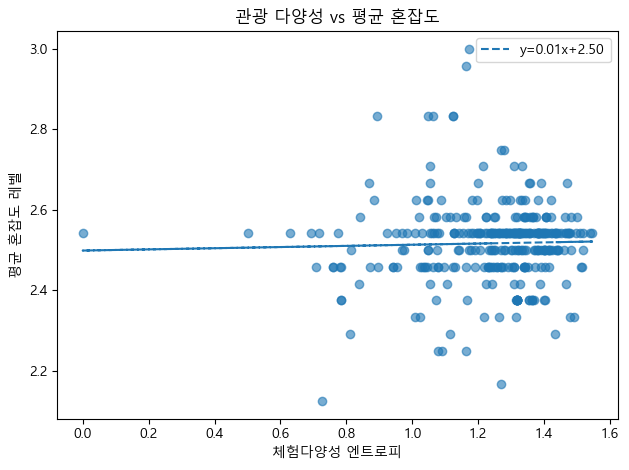

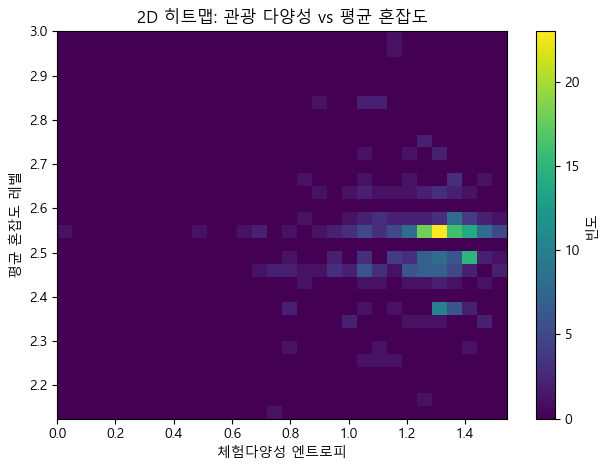

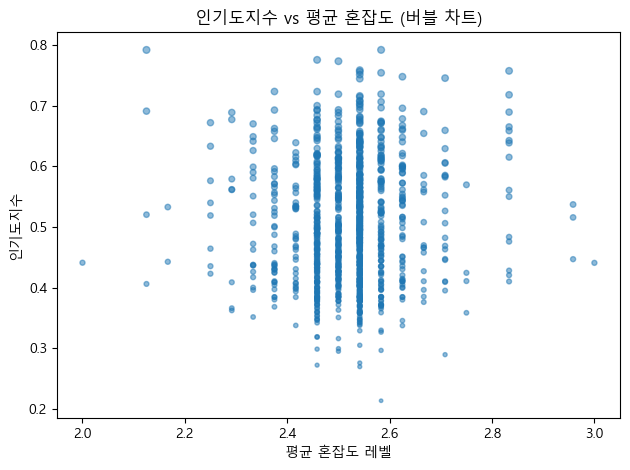

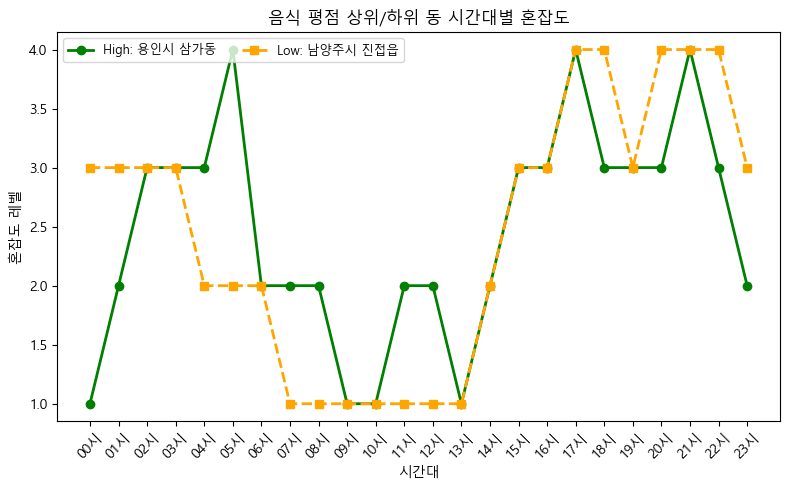

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\3879288964.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([hb, lb], labels=['상위 10%','하위 10%'])


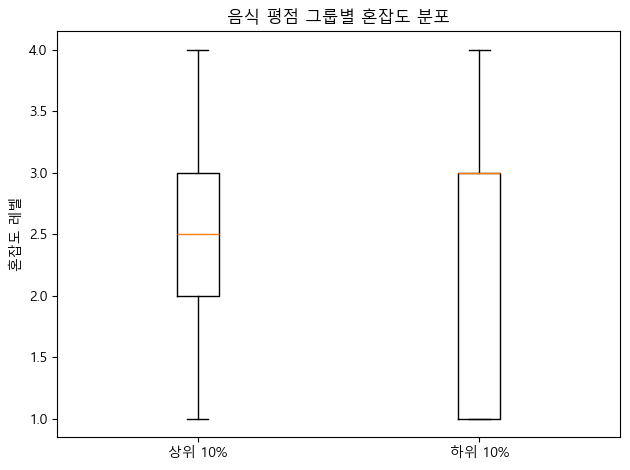

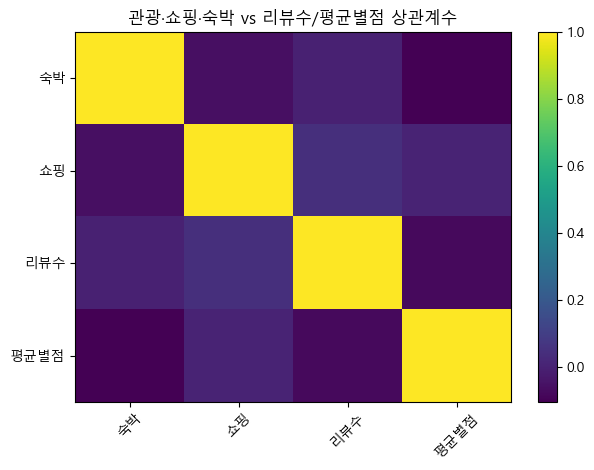

<Figure size 800x800 with 0 Axes>

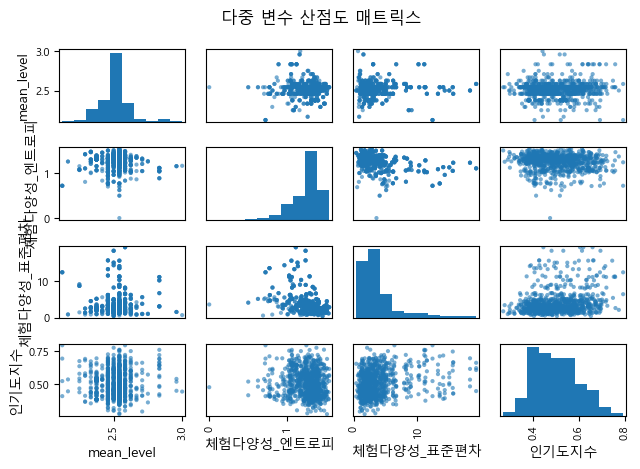

In [11]:
# 1) 산점도 + 추세선 (관광 다양성 vs 평균 혼잡도)
x = busy_tour['체험다양성_엔트로피']
y = busy_tour['mean_level']
if len(x) >= 2:
    coef = np.polyfit(x, y, 1)
    plt.figure()
    plt.scatter(x, y, alpha=0.6)
    plt.plot(x, np.polyval(coef, x), linestyle='--',
             label=f"y={coef[0]:.2f}x+{coef[1]:.2f}")
    plt.xlabel('체험다양성 엔트로피')
    plt.ylabel('평균 혼잡도 레벨')
    plt.title('관광 다양성 vs 평균 혼잡도')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2) 2D 히트맵
plt.figure()
plt.hist2d(x, y, bins=30)
plt.colorbar(label='빈도')
plt.xlabel('체험다양성 엔트로피')
plt.ylabel('평균 혼잡도 레벨')
plt.title('2D 히트맵: 관광 다양성 vs 평균 혼잡도')
plt.tight_layout()
plt.show()

# 3) 버블 차트 (인기도지수 vs 평균 혼잡도)
plt.figure()
sizes = pop_busy['인기도지수'] * 30
plt.scatter(pop_busy['mean_level'], pop_busy['인기도지수'],
            s=sizes, alpha=0.5)
plt.xlabel('평균 혼잡도 레벨')
plt.ylabel('인기도지수')
plt.title('인기도지수 vs 평균 혼잡도 (버블 차트)')
plt.tight_layout()
plt.show()

# 4) “음식” 평점 상위/하위 그룹의 시간대별 혼잡도
# 1) final_level → 숫자 레벨 맵핑
mapping = {'여유':1, '보통':2, '붐빔':3, '매우 붐빔':4}
df_busy['level_num'] = df_busy['final_level'].map(mapping)

# 2) 음식 평균별점 상위/하위 10% key 추출
food = dong_cate_stats[['key','평균별점']]
high_th = food['평균별점'].quantile(0.9)
low_th  = food['평균별점'].quantile(0.1)
high_keys = food[food['평균별점']>=high_th]['key'].tolist()[:3]
low_keys  = food[food['평균별점']<=low_th ]['key'].tolist()[:3]

# 3) 색상 및 스타일 지정
high_colors = ['blue', 'green', 'purple']
low_colors  = ['orange', 'magenta', 'red']

# 4) 플롯
plt.figure(figsize=(8,5))

for idx, k in enumerate(high_keys):
    dfk = df_busy[df_busy['key']==k]
    if dfk.empty: 
        continue   # 매칭 안 되는 key 건너뛰기
    plt.plot(dfk['시간대'], dfk['level_num'],
             label=f'High: {k}',
             color=high_colors[idx], linewidth=2, marker='o')

for idx, k in enumerate(low_keys):
    dfk = df_busy[df_busy['key']==k]
    if dfk.empty:
        continue
    plt.plot(dfk['시간대'], dfk['level_num'],
             label=f'Low: {k}',
             color=low_colors[idx], linewidth=2, linestyle='--', marker='s')

plt.xticks(rotation=45)
plt.xlabel('시간대')
plt.ylabel('혼잡도 레벨')
plt.title('음식 평점 상위/하위 동 시간대별 혼잡도')
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# 5) 박스플롯 (상위10% vs 하위10%)
hb = df_busy[df_busy['key'].isin(high_keys)]['level_num']
lb = df_busy[df_busy['key'].isin(low_keys)]['level_num']
plt.figure()
plt.boxplot([hb, lb], labels=['상위 10%','하위 10%'])
plt.ylabel('혼잡도 레벨')
plt.title('음식 평점 그룹별 혼잡도 분포')
plt.tight_layout()
plt.show()

# 6) 상관계수 히트맵 (관광·쇼핑·숙박 vs 리뷰수/평균별점)
merged = pd.merge(df_tourism2, dong_cate_stats, on='key', how='inner')
corr_df = merged[['숙박','쇼핑','리뷰수','평균별점']].corr()
plt.figure()
plt.imshow(corr_df, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_df)), corr_df.columns, rotation=45)
plt.yticks(range(len(corr_df)), corr_df.index)
plt.title('관광·쇼핑·숙박 vs 리뷰수/평균별점 상관계수')
plt.tight_layout()
plt.show()

# 7) 다중 변수 산점도 매트릭스
pair_df = pd.merge(busy_tour, pop_busy[['key','인기도지수']], on='key', how='inner')
pair_vars = pair_df[['mean_level','체험다양성_엔트로피','체험다양성_표준편차','인기도지수']]
plt.figure(figsize=(8,8))
scatter_matrix(pair_vars, diagonal='hist', alpha=0.6)
plt.suptitle('다중 변수 산점도 매트릭스')
plt.tight_layout()
plt.show()

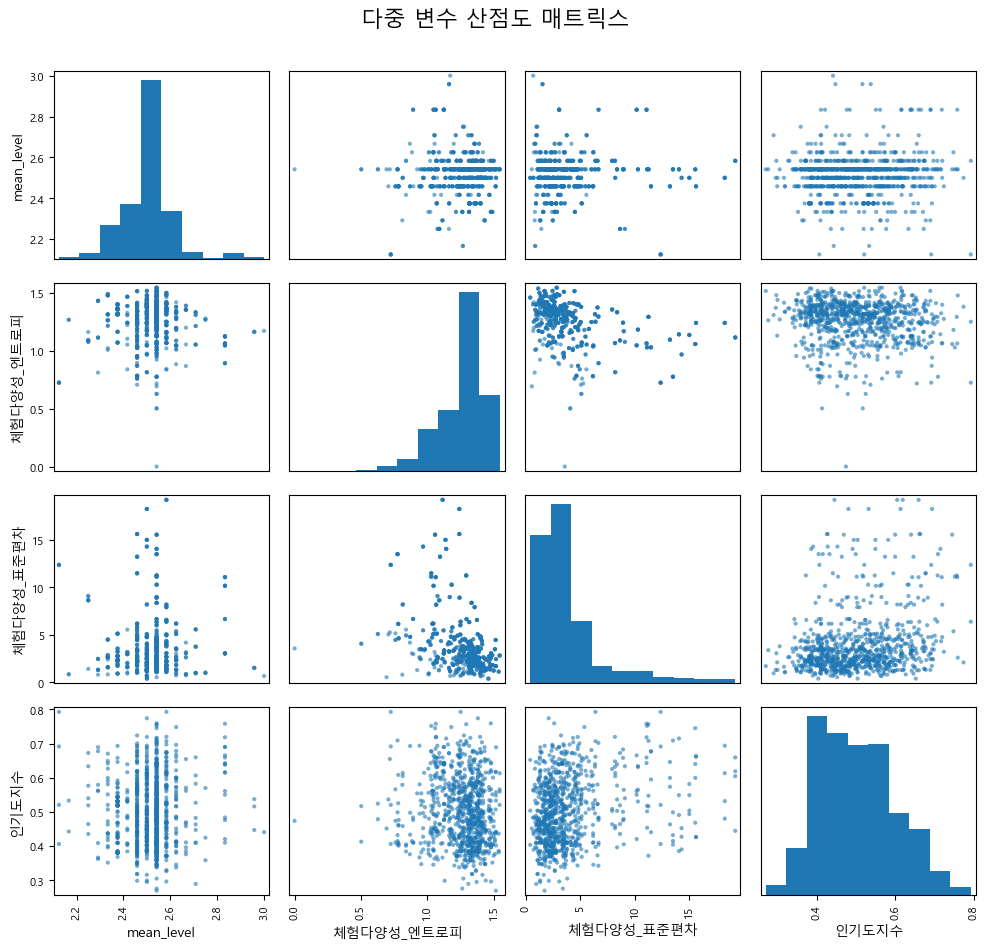

In [12]:
axes = scatter_matrix(pair_vars, diagonal='hist', alpha=0.6, figsize=(10, 10))
plt.suptitle('다중 변수 산점도 매트릭스', y=0.95, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [13]:
df_busy['key']       = df_busy['시군구'] + ' ' + df_busy['읍면동']
df_tourism2['key']   = df_tourism2['자치구'] + ' ' + df_tourism2['행정동']
dong_cate_stats['key'] = dong_cate_stats['행정구'].str.split().str[1] \
                       + ' ' + dong_cate_stats['행정동']


>> 병합 결과 Shape : (300, 7)
              X               Y         ρ
5  mean_z_score  mean_level_num  0.643109


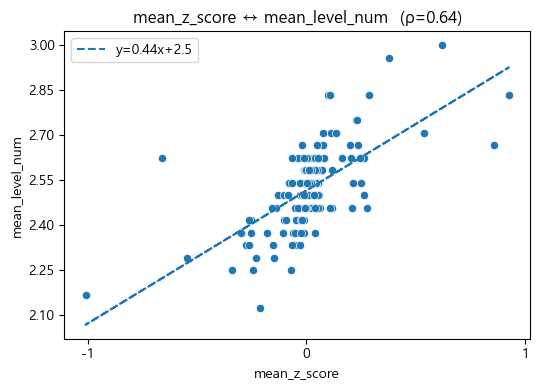

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# ──────────────────────────────────────────────────────────
# 1. Key 정규화 함수
# ──────────────────────────────────────────────────────────
def make_key(gu, dong):
    """ '구(군) 동' 형태로 통일, 공백·점 제거 """
    clean = lambda s: (str(s)
                       .strip()
                       .replace('·', '')       # 종로1·2·3·4가동 → 종로1234가동
                       .replace('(', '')
                       .replace(')', '')
                       .replace(' ','')       # 비가시 공백
                      )
    return f"{clean(gu)} {clean(dong)}"

# ──────────────────────────────────────────────────────────
# 2. 각 DF에 key 생성
# ──────────────────────────────────────────────────────────
df_busy['key'] = df_busy.apply(lambda r: make_key(r['시군구'],   r['읍면동']), axis=1)
df_tourism2['key'] = df_tourism2.apply(lambda r: make_key(r['자치구'],  r['행정동']), axis=1)

# '서울 중구' → '중구' 로 구만 추출
dong_cate_stats['구'] = dong_cate_stats['행정구'].str.split().str[-1]
dong_cate_stats['key'] = dong_cate_stats.apply(lambda r: make_key(r['구'], r['행정동']), axis=1)

# ──────────────────────────────────────────────────────────
# 3. 지표 집계 (DeprecationWarning 방지)
# ──────────────────────────────────────────────────────────
busy_agg = (df_busy
            .groupby('key', as_index=False)
            .agg(mean_busy      = ('혼잡도', 'mean'),
                 mean_z_score   = ('z_score', 'mean'),
                 mean_level_num = ('final_level_num', 'mean')))

tour_cols = ['체험다양성_엔트로피', '체험다양성_표준편차']
tour_agg  = df_tourism2[['key'] + tour_cols].drop_duplicates('key')

pop_agg = (dong_cate_stats
           .groupby('key', as_index=False)
           .apply(lambda g: pd.Series({'pop_score':
                                       np.average(g['인기도지수'],
                                                  weights=g['리뷰수'])}),
                  include_groups=False)   # ← Warning 제거
           )

# ──────────────────────────────────────────────────────────
# 4. 병합 & 상관계수 재계산
# ──────────────────────────────────────────────────────────
merged = (busy_agg
          .merge(tour_agg, on='key', how='inner')
          .merge(pop_agg, on='key', how='inner'))

print('>> 병합 결과 Shape :', merged.shape)   # 이젠 0이 아니어야 정상

num_cols = merged.select_dtypes(np.number).columns
corr_mat = merged[num_cols].corr()

# │ρ│≥0.6 필터
threshold = 0.6
high_pairs = (corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
                        .stack()
                        .reset_index()
                        .rename(columns={'level_0':'X','level_1':'Y',0:'ρ'})
                        .query('abs(ρ) >= @threshold')
                        .sort_values('ρ', ascending=False))

print(high_pairs)

# ──────────────────────────────────────────────────────────
# 5. 시각화 (필요 시 동일)
# ──────────────────────────────────────────────────────────
for _, r in high_pairs.iterrows():
    x, y, rho = r['X'], r['Y'], r['ρ']
    coeff = np.polyfit(merged[x], merged[y], 1)
    trend = np.polyval(coeff, merged[x])

    plt.figure(figsize=(5.5,4))
    sns.scatterplot(x=merged[x], y=merged[y], s=35)
    plt.plot(merged[x], trend, '--', label=f'y={coeff[0]:.2g}x+{coeff[1]:.2g}')
    plt.title(f'{x} ↔ {y}  (ρ={rho:.2f})')
    plt.xlabel(x); plt.ylabel(y); plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout(); plt.show()


In [15]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr

# ───────────────────────────────────────────────────────────
# 0) key 통일(이전 메시지의 make_key 함수 사용 가정)
# ───────────────────────────────────────────────────────────
df_busy['key']          = df_busy.apply(lambda r: make_key(r['시군구'],   r['읍면동']), axis=1)
dong_cate_stats['구']    = dong_cate_stats['행정구'].str.split().str[-1]
dong_cate_stats['key']   = dong_cate_stats.apply(lambda r: make_key(r['구'], r['행정동']), axis=1)

# ───────────────────────────────────────────────────────────
# 1) 혼잡도 지표(동 평균) ─ busy_agg
# ───────────────────────────────────────────────────────────
busy_agg = (df_busy.groupby('key', as_index=False)
                     .agg(mean_busy      = ('혼잡도', 'mean'),
                          mean_z_score   = ('z_score', 'mean'),
                          mean_level_num = ('final_level_num', 'mean')))

# ───────────────────────────────────────────────────────────
# 2) 테마별 인기도지수 (리뷰수 가중 평균) ─ pop_theme_agg
# ───────────────────────────────────────────────────────────
pop_theme_agg = (
    dong_cate_stats
      .groupby(['key','카테고리'], as_index=False)
      .apply(lambda g: pd.Series({'pop_score':
                                  np.average(g['인기도지수'],
                                             weights=g['리뷰수'])}),
             include_groups=False)
)

# ───────────────────────────────────────────────────────────
# 3) 혼잡 + 인기도 병합
# ───────────────────────────────────────────────────────────
theme_merge = pop_theme_agg.merge(busy_agg, on='key', how='inner')

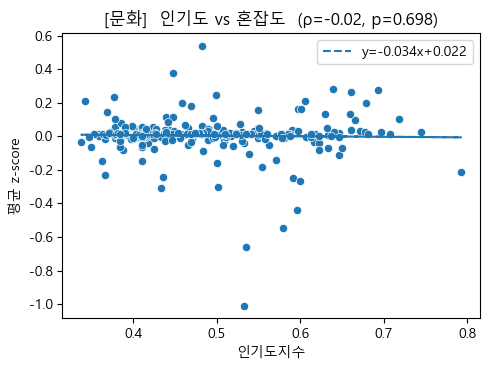

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\1296082387.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pop_group', y='mean_z_score', data=g,


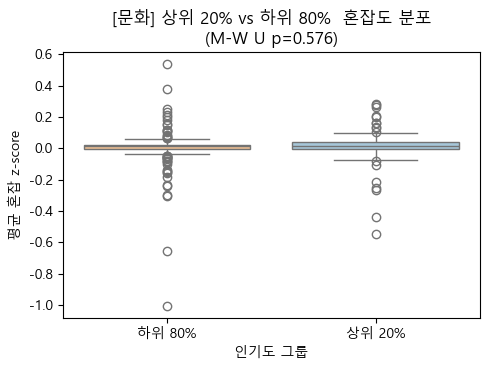

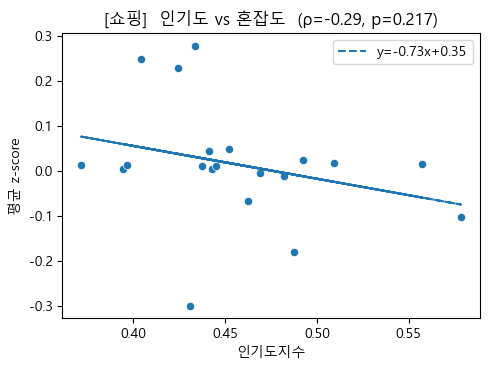

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\1296082387.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pop_group', y='mean_z_score', data=g,


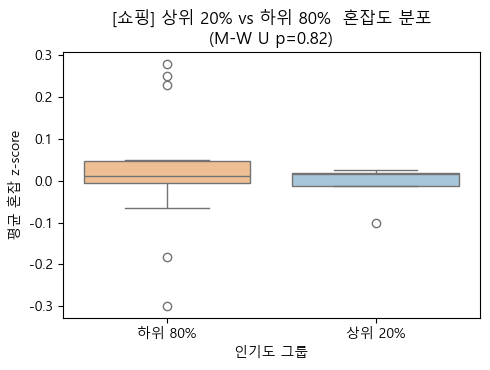

skip: '숙박' 표본 1개


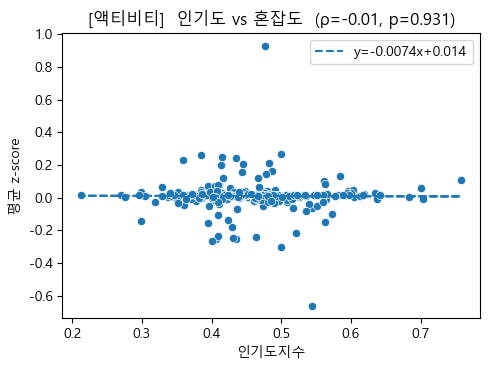

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\1296082387.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pop_group', y='mean_z_score', data=g,


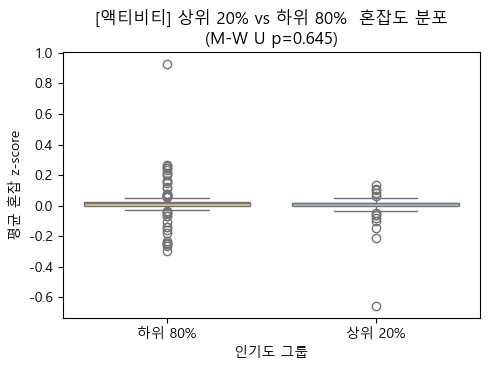

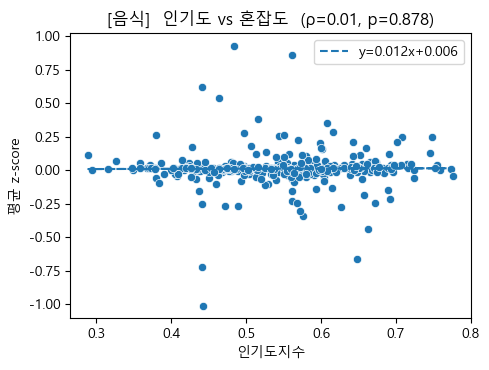

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\1296082387.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pop_group', y='mean_z_score', data=g,


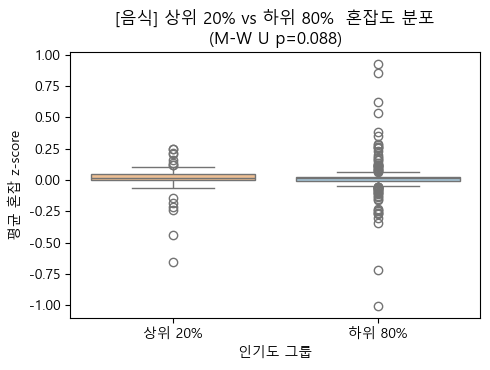

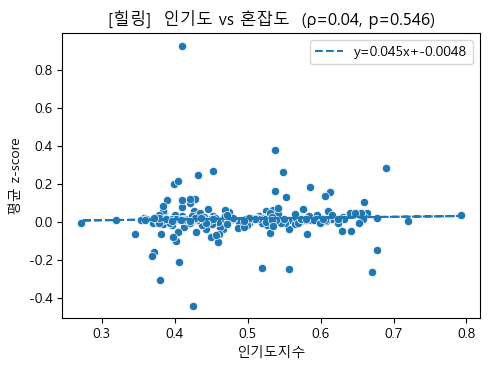

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\1296082387.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pop_group', y='mean_z_score', data=g,


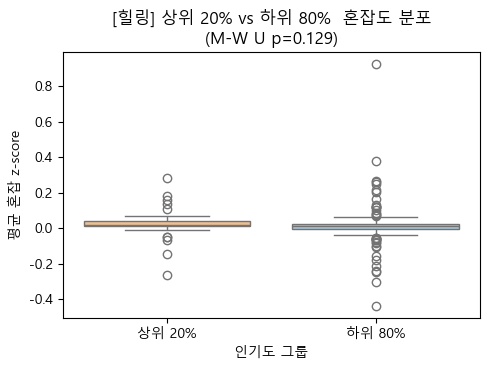

In [16]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr, mannwhitneyu

MIN_SAMPLE = 3     # ← 카테고리별 최소 행정동 수

results = []       # 요약 테이블용

for cate, g in theme_merge.groupby('카테고리'):

    # ── 0) 표본 부족 카테고리 스킵
    if len(g) < MIN_SAMPLE:
        print(f"skip: '{cate}' 표본 {len(g)}개")
        continue

    # ── 1) 상관계수
    rho, p = pearsonr(g['pop_score'], g['mean_z_score'])
    results.append([cate, len(g), rho, p])

    # ── 2) 산점도 + 회귀선
    coef  = np.polyfit(g['pop_score'], g['mean_z_score'], 1)
    trend = np.polyval(coef, g['pop_score'])

    plt.figure(figsize=(5,3.8))
    sns.scatterplot(x='pop_score', y='mean_z_score', data=g, s=35)
    plt.plot(g['pop_score'], trend, '--',
             label=f'y={coef[0]:.2g}x+{coef[1]:.2g}')
    plt.title(f"[{cate}]  인기도 vs 혼잡도  (ρ={rho:.2f}, p={p:.3g})")
    plt.xlabel('인기도지수'); plt.ylabel('평균 z-score'); plt.legend()
    plt.tight_layout(); plt.show()

    # ── 3) 상위 20 % vs 하위 80 % 박스플롯 + U‑test
    q80 = g['pop_score'].quantile(0.8)
    g['pop_group'] = np.where(g['pop_score'] >= q80, '상위 20%', '하위 80%')

    top  = g.loc[g['pop_group']=='상위 20%','mean_z_score']
    rest = g.loc[g['pop_group']=='하위 80%','mean_z_score']
    U, p_u = mannwhitneyu(top, rest, alternative='two-sided')

    plt.figure(figsize=(5,3.8))
    sns.boxplot(x='pop_group', y='mean_z_score', data=g,
                palette=['#FDBE85','#9ECAE1'])
    plt.title(f"[{cate}] 상위 20% vs 하위 80%  혼잡도 분포\n"
              f"(M-W U p={p_u:.3g})")
    plt.xlabel('인기도 그룹'); plt.ylabel('평균 혼잡 z-score')
    plt.tight_layout(); plt.show()


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import spearmanr, mannwhitneyu
import statsmodels.formula.api as smf

# ------------------------------------------------------------
# 0) 유틸: key/gu_key 생성 함수
# ------------------------------------------------------------
def make_key(gu, dong):
    clean = lambda s: (
        str(s).strip()
             .replace('·','')
             .replace('(','')
             .replace(')','')
    )
    return f"{clean(gu)} {clean(dong)}"

# ------------------------------------------------------------
# 1) key 컬럼 붙이기
# ------------------------------------------------------------
# df_busy: (시군구, 읍면동) → key, gu_key
df_busy['key']    = df_busy.apply(lambda r: make_key(r['시군구'],   r['읍면동']), axis=1)
df_busy['gu_key'] = df_busy['시군구']

# dong_cate_stats: (행정구, 행정동) → key, gu_key
dong_cate_stats['구']      = dong_cate_stats['행정구'].str.split().str[-1]
dong_cate_stats['key']     = dong_cate_stats.apply(lambda r: make_key(r['구'], r['행정동']), axis=1)
dong_cate_stats['gu_key']  = dong_cate_stats['구']

# ------------------------------------------------------------
# 2) 혼잡 지표 집계: 전체평균 z, 피크타임(11~17시)평균 z, high_ratio (레벨3·4 비율)
# ------------------------------------------------------------
# 피크타임 마스크
df_busy['hour']    = df_busy['시간대'].str[:-1].astype(int)
df_busy['is_peak'] = df_busy['hour'].between(11, 17)

# 동(key) 단위
busy_agg = (
    df_busy.groupby('key', as_index=False)
           .agg(
               mean_z_all  = ('z_score', 'mean'),
               mean_z_peak = ('z_score', lambda x: x[df_busy.loc[x.index,'is_peak']].mean()),
               high_ratio  = ('final_level_num', lambda x: (x>=3).mean())
           )
)
# 구(gu_key) 단위
busy_agg_gu = (
    df_busy.groupby('gu_key', as_index=False)
           .agg(
               mean_z_all  = ('z_score', 'mean'),
               mean_z_peak = ('z_score', lambda x: x[df_busy.loc[x.index,'is_peak']].mean()),
               high_ratio  = ('final_level_num', lambda x: (x>=3).mean())
           )
).add_suffix('_gu')
busy_agg_gu.rename(columns={'gu_key_gu':'gu_key'}, inplace=True)

# ------------------------------------------------------------
# 3) 테마별 인기도지수 (리뷰수 가중 평균)
# ------------------------------------------------------------
pop_theme = (
    dong_cate_stats
      .groupby(['key','gu_key','카테고리'], as_index=False)
      .apply(
          lambda g: pd.Series({'pop_score': np.average(g['인기도지수'], weights=g['리뷰수'])}),
          include_groups=False
      )
)

# ------------------------------------------------------------
# 4) 병합: key 단위 / gu 단위
# ------------------------------------------------------------
theme_key = pop_theme.merge(busy_agg,      on='key',    how='inner')
theme_gu  = pop_theme.merge(busy_agg_gu,   on='gu_key', how='inner')

# ------------------------------------------------------------
# 5) 상관분석 요약 함수
# ------------------------------------------------------------
def corr_summary(df, z_col):
    rows = []
    for cate, g in df.groupby('카테고리'):
        if len(g) < 3: 
            continue
        # Spearman 상관 & p-value
        rho, p_val = spearmanr(g['pop_score'], g[z_col])
        # 상위 20% vs 하위 80% Mann-Whitney U-test
        q80 = g['pop_score'].quantile(0.8)
        top  = g.loc[g['pop_score'] >= q80, z_col]
        rest = g.loc[g['pop_score'] <  q80, z_col]
        U, p_u = mannwhitneyu(top, rest, alternative='two-sided')
        rows.append([cate, len(g), rho, p_val, p_u])
    return pd.DataFrame(rows, columns=['테마','N',f'ρ({z_col})','p','U-p'])

# 5-1) key 기반
key_res_all  = corr_summary(theme_key, 'mean_z_all')
key_res_peak = corr_summary(theme_key, 'mean_z_peak')
key_res_high = corr_summary(theme_key, 'high_ratio')

# 5-2) gu 기반
gu_res_all  = corr_summary(theme_gu, 'mean_z_all_gu')
gu_res_peak = corr_summary(theme_gu, 'mean_z_peak_gu')
gu_res_high = corr_summary(theme_gu, 'high_ratio_gu')

# 결과 출력
print("=== 행정동(key) 기반 ===")
print("전체 시간 z");   display(key_res_all)
print("피크타임 z");    display(key_res_peak)
print("high_ratio");    display(key_res_high)

print("\n=== 자치구(gu_key) 기반 ===")
print("전체 시간 z");   display(gu_res_all)
print("피크타임 z");    display(gu_res_peak)
print("high_ratio");    display(gu_res_high)

# ------------------------------------------------------------
# 6) 회귀모형: 피크타임 혼잡도 예측 → pop_score * 카테고리 교호항
# ------------------------------------------------------------
reg_df = theme_key.dropna(subset=['mean_z_peak'])
model  = smf.ols('mean_z_peak ~ pop_score * C(카테고리)', data=reg_df).fit()
print("\n=== 회귀 모델 요약 ===")
print(model.summary())


=== 행정동(key) 기반 ===
전체 시간 z


,테마,N,ρ(mean_z_all),p,U-p
0,문화,244,0.024134,0.707584,0.576006
1,쇼핑,20,-0.255639,0.276664,0.819814
2,액티비티,231,-0.041890,0.526409,0.644799
3,음식,335,0.060805,0.267091,0.088050
4,힐링,228,0.121594,0.066840,0.128545


피크타임 z


,테마,N,ρ(mean_z_peak),p,U-p
0,문화,244,0.064080,0.318840,0.940442
1,쇼핑,20,-0.084211,0.724104,0.963467
2,액티비티,231,0.068188,0.302099,0.116680
3,음식,335,0.043860,0.423618,0.180999
4,힐링,228,0.037857,0.569568,0.544054


high_ratio


,테마,N,ρ(high_ratio),p,U-p
0,문화,244,0.009678,0.880446,0.644661
1,쇼핑,20,-0.219363,0.352763,0.540942
2,액티비티,231,-0.085397,0.195926,0.479959
3,음식,335,0.048913,0.372156,0.572497
4,힐링,228,0.070983,0.285845,0.725042



=== 자치구(gu_key) 기반 ===
전체 시간 z


,테마,N,ρ(mean_z_all_gu),p,U-p
0,문화,532,0.007691,0.859529,0.107721
1,쇼핑,120,-0.044421,0.629984,0.261560
2,액티비티,448,-0.107175,0.023288,0.270680
3,음식,1127,0.005873,0.843866,0.944679
4,힐링,550,0.006116,0.886202,0.687990


피크타임 z


,테마,N,ρ(mean_z_peak_gu),p,U-p
0,문화,532,0.085837,0.047835,0.147012
1,쇼핑,120,-0.007502,0.935182,0.664777
2,액티비티,448,0.069930,0.139455,0.053085
3,음식,1127,0.058776,0.048531,0.009257
4,힐링,550,0.051478,0.228080,0.707351


high_ratio


,테마,N,ρ(high_ratio_gu),p,U-p
0,문화,532,-0.078807,0.069333,0.000448
1,쇼핑,120,0.008421,0.927267,0.074143
2,액티비티,448,-0.133405,0.004678,0.013655
3,음식,1127,-0.054854,0.065644,0.001490
4,힐링,550,-0.069220,0.104886,0.136122



=== 회귀 모델 요약 ===
                            OLS Regression Results                            
Dep. Variable:            mean_z_peak   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9915
Date:                Fri, 09 May 2025   Prob (F-statistic):              0.449
Time:                        19:54:16   Log-Likelihood:                -628.05
No. Observations:                1059   AIC:                             1278.
Df Residuals:                    1048   BIC:                             1333.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Inte

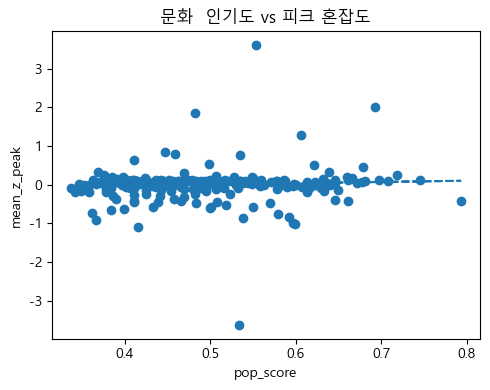

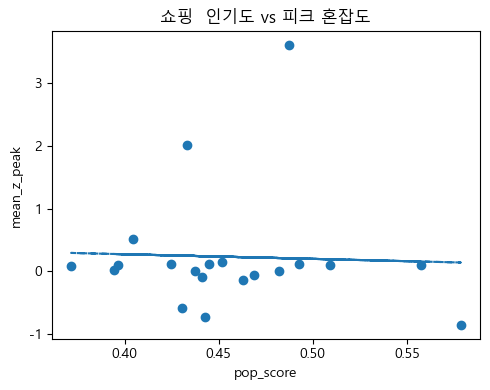

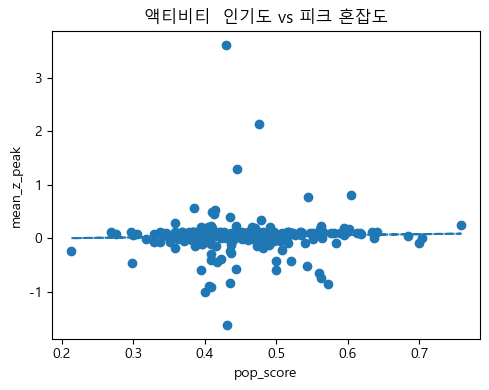

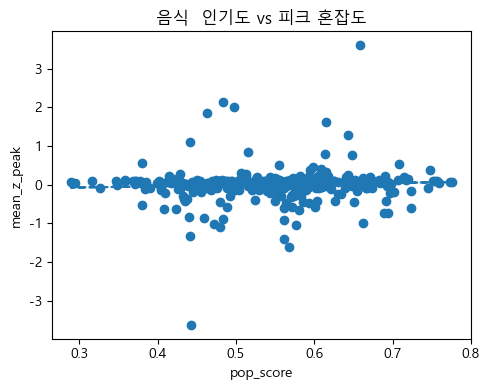

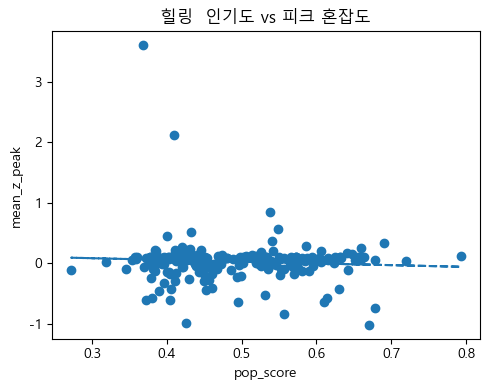

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\4150862358.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rest, top], labels=["하위 80%", "상위 20%"])


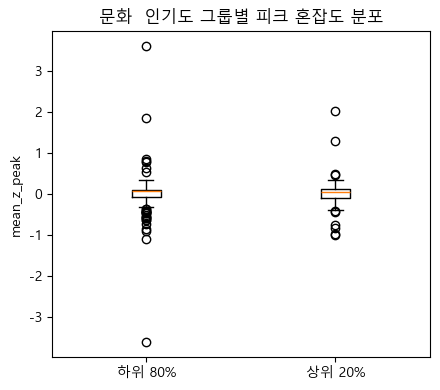

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\4150862358.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rest, top], labels=["하위 80%", "상위 20%"])


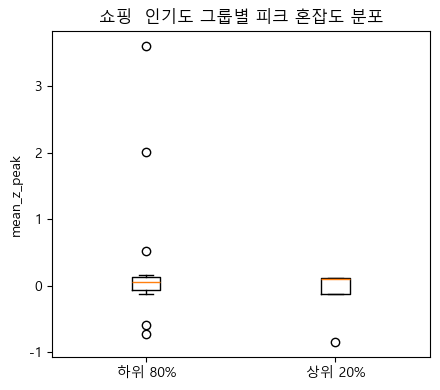

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\4150862358.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rest, top], labels=["하위 80%", "상위 20%"])


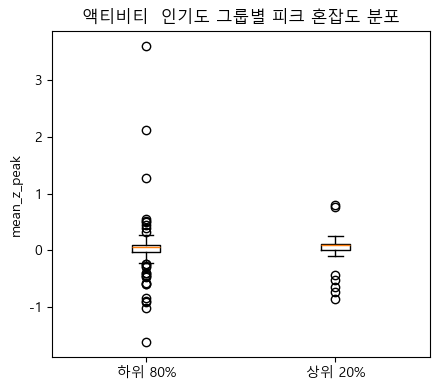

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\4150862358.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rest, top], labels=["하위 80%", "상위 20%"])


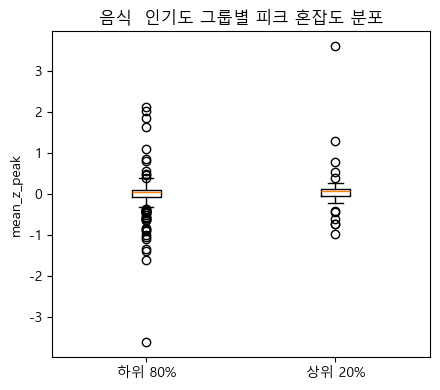

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\4150862358.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rest, top], labels=["하위 80%", "상위 20%"])


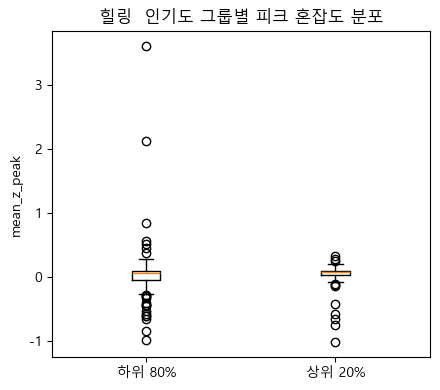

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 이 스크립트는 theme_key DataFrame(행정동‑단위 병합 결과)을 이미 메모리에
# 가지고 있다고 가정합니다. 만약 없다면, 앞서 드린 “풀 스크립트”를 먼저
# 실행해 theme_key를 만든 뒤 다시 실행해 주세요.

# ------------------------------------------------------------
# 1) 카테고리별 산점도 + 1차 회귀선
# ------------------------------------------------------------
for cate, g in theme_key.groupby("카테고리"):
    if len(g) < 3:        # 표본 3개 미만은 스킵
        continue

    x = g["pop_score"]
    y = g["mean_z_peak"]    # 피크(11–17시) 시간대 혼잡 z

    # 1차 회귀선 계수
    coef = np.polyfit(x, y, 1)
    trend = np.polyval(coef, x)

    plt.figure(figsize=(5, 4))
    plt.scatter(x, y)                     # 산점도
    plt.plot(x, trend, linestyle="--")    # 회귀선
    plt.title(f"{cate}  인기도 vs 피크 혼잡도")
    plt.xlabel("pop_score")
    plt.ylabel("mean_z_peak")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 2) 카테고리별 인기도 상위 20% vs 하위 80%  박스플롯
# ------------------------------------------------------------
for cate, g in theme_key.groupby("카테고리"):
    if len(g) < 3:
        continue

    q80 = g["pop_score"].quantile(0.8)
    top  = g[g["pop_score"] >= q80]["mean_z_peak"]
    rest = g[g["pop_score"] <  q80]["mean_z_peak"]

    plt.figure(figsize=(4.5, 4))
    plt.boxplot([rest, top], labels=["하위 80%", "상위 20%"])
    plt.title(f"{cate}  인기도 그룹별 피크 혼잡도 분포")
    plt.ylabel("mean_z_peak")
    plt.tight_layout()
    plt.show()


In [19]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# 테마별 pop_score와 mean_z_peak 간 상관계수 계산
results = []
for cate, g in theme_key.groupby("카테고리"):
    if len(g) < 3:        # 표본이 3개 미만이면 스킵
        continue

    # Pearson 상관계수 및 p-value
    pear_r, pear_p = pearsonr(g["pop_score"], g["mean_z_peak"])
    # Spearman 상관계수 및 p-value
    spear_r, spear_p = spearmanr(g["pop_score"], g["mean_z_peak"])
    
    results.append({
        "카테고리": cate,
        "N (표본수)": len(g),
        "Pearson r": pear_r,
        "Pearson p": pear_p,
        "Spearman r": spear_r,
        "Spearman p": spear_p
    })

# DataFrame으로 변환 후 출력
corr_df = pd.DataFrame(results)
print("▶ 카테고리별 pop_score vs mean_z_peak 상관계수")
display(corr_df)


▶ 카테고리별 pop_score vs mean_z_peak 상관계수


,카테고리,N (표본수),Pearson r,Pearson p,Spearman r,Spearman p
0,문화,244,0.064927,0.312468,0.064080,0.318840
1,쇼핑,20,-0.039484,0.868730,-0.084211,0.724104
2,액티비티,231,0.032995,0.617848,0.068188,0.302099
3,음식,335,0.061615,0.260759,0.043860,0.423618
4,힐링,228,-0.073116,0.271579,0.037857,0.569568


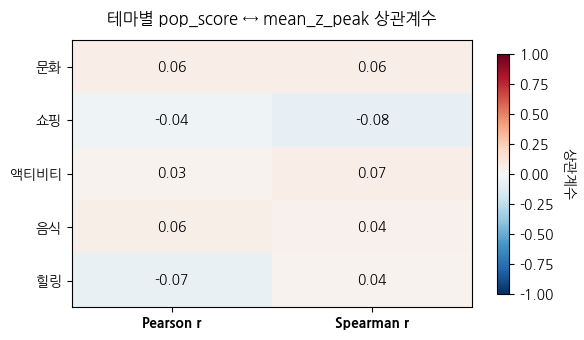

In [32]:
import matplotlib.pyplot as plt
import numpy as np

heatmap = corr_df.set_index("카테고리")[["Pearson r", "Spearman r"]]

fig, ax = plt.subplots(figsize=(6, 0.5 * len(heatmap) + 1))

# ▶ 팔레트만 바꾼 부분
im = ax.imshow(
    heatmap,
    aspect="auto",
    vmin=-1, vmax=1,          # 다이버징이라 범위 고정
    cmap="RdBu_r"             # ← 여기!
)

ax.set_xticks(np.arange(heatmap.shape[1]))
ax.set_yticks(np.arange(heatmap.shape[0]))
ax.set_xticklabels(heatmap.columns, fontsize=10, weight="bold")
ax.set_yticklabels(heatmap.index, fontsize=10)

# 셀 내부 숫자
for i in range(heatmap.shape[0]):
    for j in range(heatmap.shape[1]):
        val = heatmap.iat[i, j]
        ax.text(
            j, i, f"{val:.2f}",
            ha="center", va="center",
            color="white" if abs(val) > 0.5 else "black"
        )

cbar = fig.colorbar(im, ax=ax, shrink=0.9)
cbar.set_label("상관계수", rotation=270, labelpad=15)

ax.set_title("테마별 pop_score ↔ mean_z_peak 상관계수", pad=12, fontsize=12)
plt.tight_layout()
plt.show()


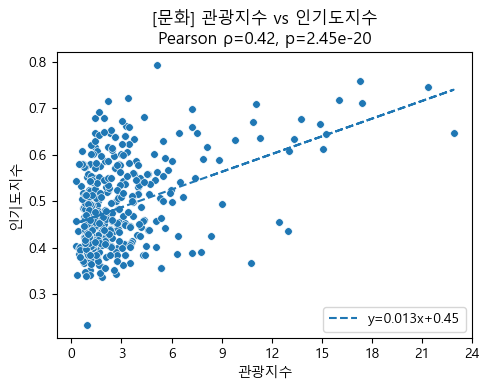

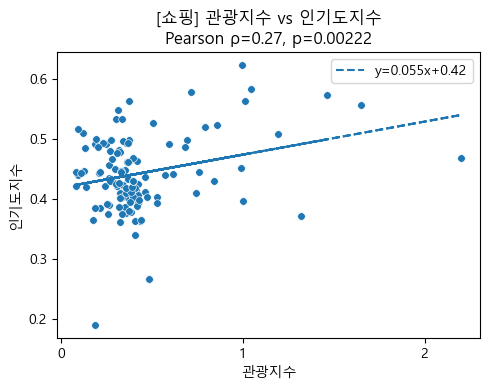

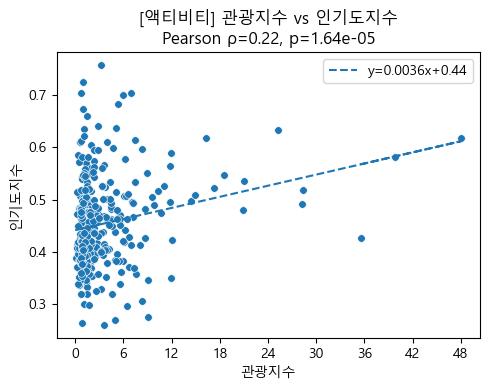

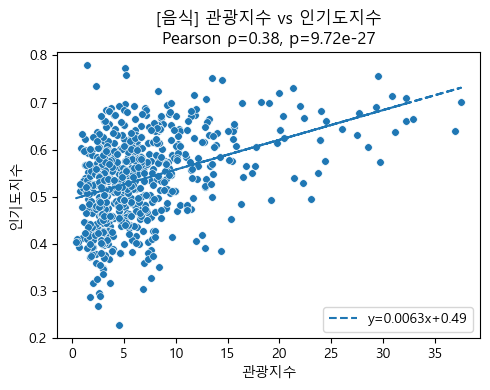

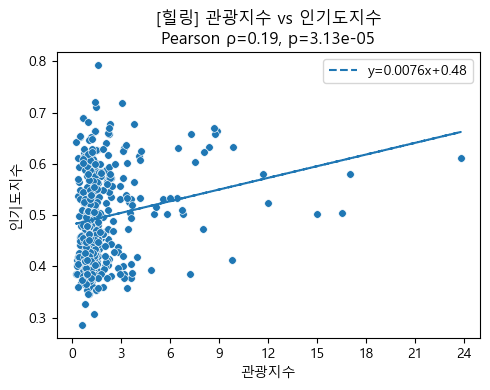

▶ 테마별 관광지수·인기도지수 상관계수


,카테고리,N,Pearson ρ,Pearson p,Spearman ρ,Spearman p
0,문화,453,0.415531,2.446737e-20,0.275859,2.352896e-09
1,쇼핑,126,0.270131,2.220252e-03,0.048381,5.905947e-01
2,액티비티,391,0.216015,1.641946e-05,0.221600,9.736504e-06
3,음식,721,0.383935,9.717287e-27,0.369094,1.090301e-24
4,힐링,459,0.193059,3.125749e-05,0.196592,2.217193e-05


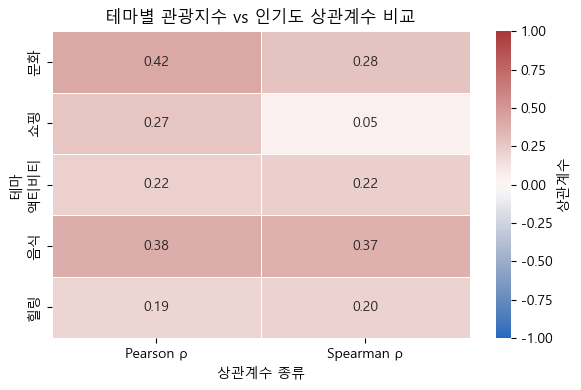

In [25]:
# ----------------------------------------------------------------

# 1) key 생성 함수
def make_key(gu, dong):
    clean = lambda s: str(s).strip().replace('·','').replace('(','').replace(')','')
    return f"{clean(gu)} {clean(dong)}"

# 2) key 컬럼 추가
df_tourism2['key'] = df_tourism2.apply(lambda r: make_key(r['자치구'], r['행정동']), axis=1)
dong_cate_stats['구']   = dong_cate_stats['행정구'].str.split().str[-1]
dong_cate_stats['key'] = dong_cate_stats.apply(lambda r: make_key(r['구'], r['행정동']), axis=1)

# 3) Tourism 데이터 long 형식으로 변환 (테마별 관광지수)
themes = ['힐링','액티비티','문화','음식','쇼핑','숙박']
tour_long = df_tourism2.melt(
    id_vars=['key'], 
    value_vars=themes, 
    var_name='카테고리', 
    value_name='tour_index'
).dropna(subset=['tour_index'])

# 4) Popularity 데이터 준비 (인기도지수)
pop_df = dong_cate_stats[['key','카테고리','리뷰수','인기도지수']].copy()
pop_df.rename(columns={'인기도지수':'pop_index'}, inplace=True)

# 5) merge
merged = pd.merge(tour_long, pop_df, on=['key','카테고리'], how='inner')

# 6) 카테고리별 상관계수 계산 및 산점도+회귀선
results = []
for cate, g in merged.groupby('카테고리'):
    if len(g) < 3:
        continue
    # Pearson & Spearman
    pear_r, pear_p = pearsonr(g['tour_index'], g['pop_index'])
    spear_r, spear_p = spearmanr(g['tour_index'], g['pop_index'])
    results.append([cate, len(g), pear_r, pear_p, spear_r, spear_p])
    
    # 산점도 + 추세선
    coef = np.polyfit(g['tour_index'], g['pop_index'], 1)
    trend = np.polyval(coef, g['tour_index'])
    
    plt.figure(figsize=(5,4))
    sns.scatterplot(x='tour_index', y='pop_index', data=g, s=30)
    plt.plot(g['tour_index'], trend, '--', label=f'y={coef[0]:.2g}x+{coef[1]:.2g}')
    plt.title(f"[{cate}] 관광지수 vs 인기도지수\nPearson ρ={pear_r:.2f}, p={pear_p:.3g}")
    plt.xlabel('관광지수')
    plt.ylabel('인기도지수')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# 7) 결과 테이블
results_df = pd.DataFrame(results, columns=[
    '카테고리','N','Pearson ρ','Pearson p','Spearman ρ','Spearman p'
])
print("▶ 테마별 관광지수·인기도지수 상관계수")
display(results_df)

# ------------------------------------------------------------
# 6) **테마별 상관계수 Heatmap** 추가
# ------------------------------------------------------------
# res_df를 인덱스-컬럼 재배열
heat_df = results_df.set_index('카테고리')[['Pearson ρ', 'Spearman ρ']]

plt.figure(figsize=(6,4))
sns.heatmap(
    heat_df,
    annot=True,
    fmt='.2f',
    cmap='vlag',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': '상관계수'}
)
plt.title('테마별 관광지수 vs 인기도 상관계수 비교')
plt.ylabel('테마')
plt.xlabel('상관계수 종류')
plt.tight_layout()
plt.show()


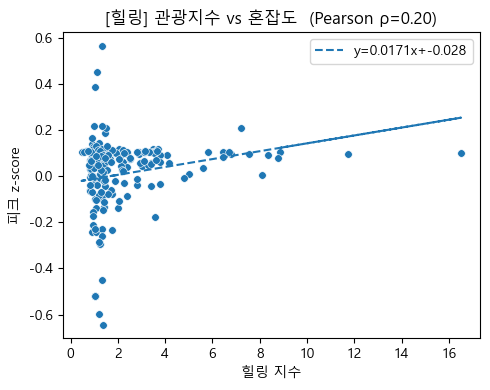

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\3224233556.py:82: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[rest, top], palette=['#9ECAE1','#FDBE85'])


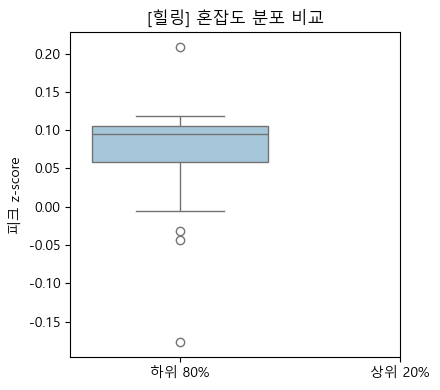

  → M-W U p-value for 힐링: 0.00174


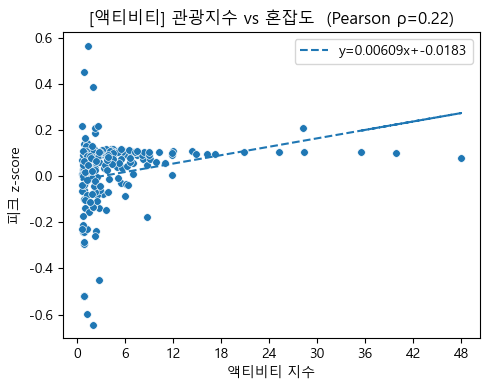

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\3224233556.py:82: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[rest, top], palette=['#9ECAE1','#FDBE85'])


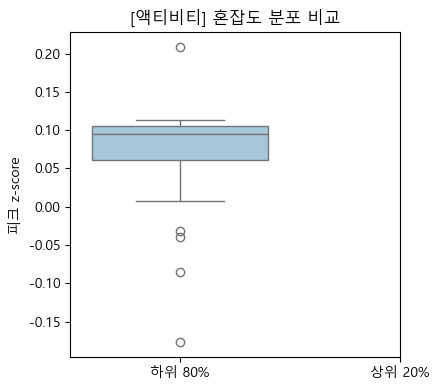

  → M-W U p-value for 액티비티: 0.00138


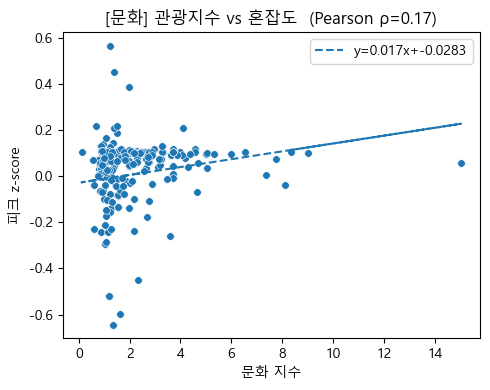

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\3224233556.py:82: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[rest, top], palette=['#9ECAE1','#FDBE85'])


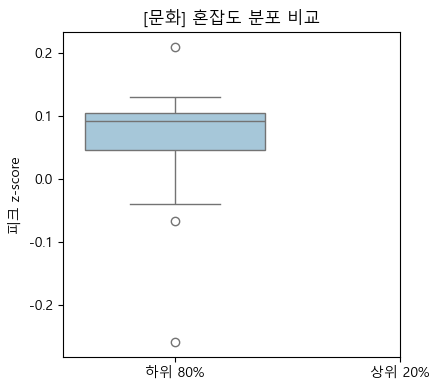

  → M-W U p-value for 문화: 0.00505


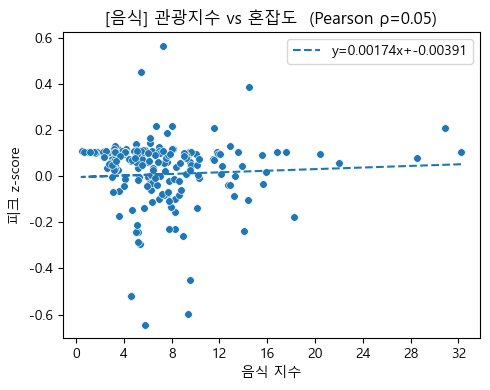

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\3224233556.py:82: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[rest, top], palette=['#9ECAE1','#FDBE85'])


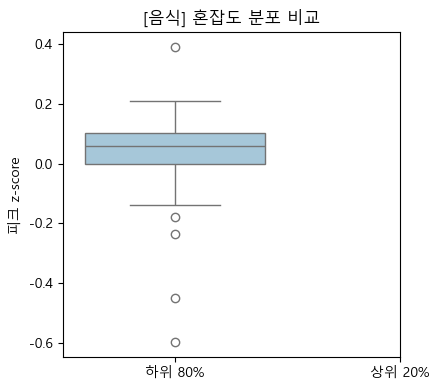

  → M-W U p-value for 음식: 0.979


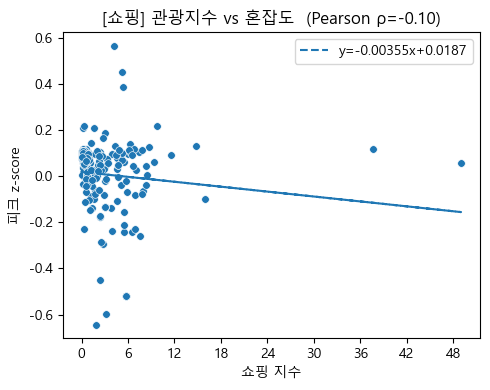

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\3224233556.py:82: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[rest, top], palette=['#9ECAE1','#FDBE85'])


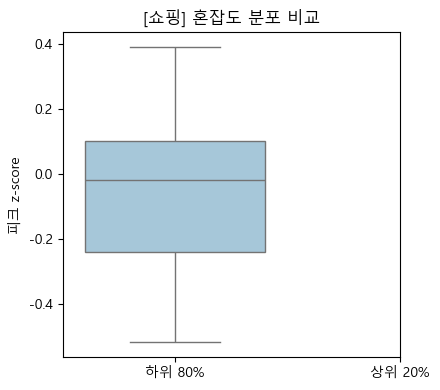

  → M-W U p-value for 쇼핑: 0.00897


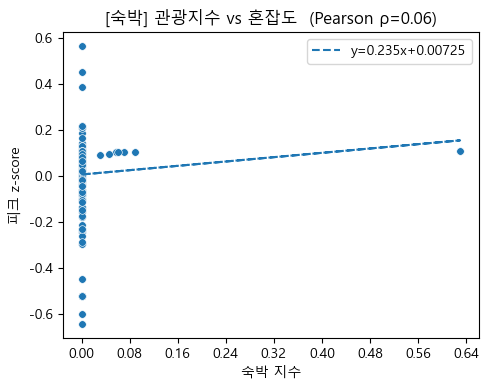

C:\Users\hyunj\AppData\Local\Temp\ipykernel_24248\3224233556.py:82: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[rest, top], palette=['#9ECAE1','#FDBE85'])


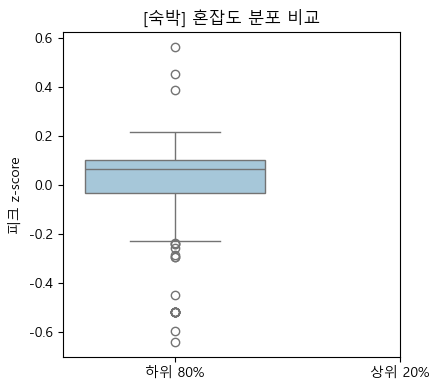

  → M-W test skipped for 숙박 (그룹 크기 부족)

▶ 테마별 관광지수 vs 혼잡도 상관분석 결과


,테마,N,Pearson ρ,Pearson p,Spearman ρ,Spearman p
0,힐링,211,0.195602,0.004344,0.242806,3.716747e-04
1,액티비티,211,0.220226,0.001284,0.379163,1.279396e-08
2,문화,211,0.170268,0.013260,0.238442,4.767063e-04
3,음식,211,0.047114,0.496074,-0.140652,4.123931e-02
4,쇼핑,211,-0.100685,0.144965,-0.342648,3.342932e-07
5,숙박,211,0.060453,0.382277,0.161620,1.881439e-02


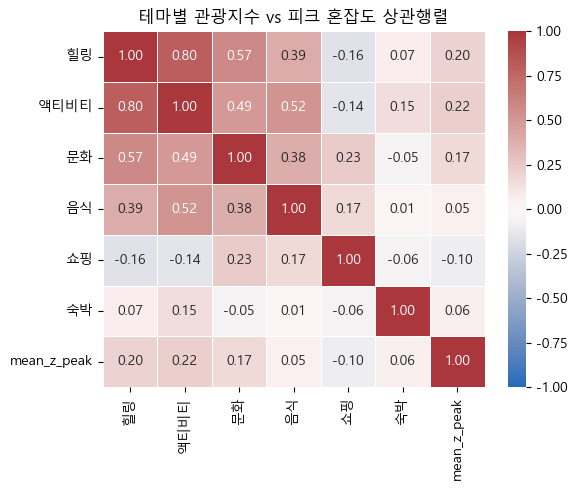

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
from matplotlib.ticker import MaxNLocator

# ------------------------------------------------------------
# 0) Key 생성 함수
# ------------------------------------------------------------
def make_key(gu, dong):
    clean = lambda s: str(s).strip().replace('·','').replace('(','').replace(')','')
    return f"{clean(gu)} {clean(dong)}"

# ------------------------------------------------------------
# 1) df_busy: 피크(11~17시) 혼잡도 z-score 평균
# ------------------------------------------------------------
df_busy['hour']    = df_busy['시간대'].str[:-1].astype(int)
df_busy['is_peak'] = df_busy['hour'].between(11,17)
df_busy['key']     = df_busy.apply(lambda r: make_key(r['시군구'], r['읍면동']), axis=1)

busy_peak = (
    df_busy[df_busy['is_peak']]
      .groupby('key', as_index=False)
      .agg(mean_z_peak=('z_score','mean'))
)

# ------------------------------------------------------------
# 2) df_tourism2: 테마별 관광지수, key 생성
# ------------------------------------------------------------
themes = ['힐링','액티비티','문화','음식','쇼핑','숙박']
df_tourism2['key'] = df_tourism2.apply(lambda r: make_key(r['자치구'], r['행정동']), axis=1)

# ------------------------------------------------------------
# 3) busy_peak + 관광지수 병합
# ------------------------------------------------------------
merged = pd.merge(
    busy_peak,
    df_tourism2[['key'] + themes],
    on='key', how='inner'
).dropna(subset=themes)

# ------------------------------------------------------------
# 4) 테마별 분석 루프
# ------------------------------------------------------------
results = []
for theme in themes:
    tmp = merged[['key', theme, 'mean_z_peak']].dropna()
    N = len(tmp)
    if N < 3:
        print(f"skip {theme}: 표본 {N}개로 부족")
        continue

    x = tmp[theme]
    y = tmp['mean_z_peak']

    # 4-1) Pearson/Spearman
    pear_r, pear_p   = pearsonr(x, y)
    spear_r, spear_p = spearmanr(x, y)
    results.append([theme, N, pear_r, pear_p, spear_r, spear_p])

    # 4-2) 산점도 + 회귀선
    coef  = np.polyfit(x, y, 1)
    trend = np.polyval(coef, x)
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=x, y=y, s=30)
    plt.plot(x, trend, '--', label=f'y={coef[0]:.3g}x+{coef[1]:.3g}')
    plt.title(f"[{theme}] 관광지수 vs 혼잡도  (Pearson ρ={pear_r:.2f})")
    plt.xlabel(f"{theme} 지수")
    plt.ylabel("피크 z-score")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

    # 4-3) 상위20% vs 하위80% 박스플롯 + U-test (그룹 크기 확인)
    q80 = tmp[theme].quantile(0.8)
    top  = tmp.loc[tmp[theme]>=q80, 'mean_z_peak']
    rest = tmp.loc[tmp[theme]< q80, 'mean_z_peak']

    plt.figure(figsize=(4.5,4))
    sns.boxplot(data=[rest, top], palette=['#9ECAE1','#FDBE85'])
    plt.xticks([0,1], ['하위 80%','상위 20%'])
    plt.title(f"[{theme}] 혼잡도 분포 비교")
    plt.ylabel("피크 z-score")
    plt.tight_layout()
    plt.show()

    if len(rest) >= 2 and len(top) >= 2:
        U, p_u = mannwhitneyu(top, rest, alternative='two-sided')
        print(f"  → M-W U p-value for {theme}: {p_u:.3g}")
    else:
        print(f"  → M-W test skipped for {theme} (그룹 크기 부족)")

# 4-끝) 결과 요약 테이블
cols = ['테마','N','Pearson ρ','Pearson p','Spearman ρ','Spearman p']
res_df = pd.DataFrame(results, columns=cols)
print("\n▶ 테마별 관광지수 vs 혼잡도 상관분석 결과")
display(res_df)

# ------------------------------------------------------------
# 5) 전체 Heatmap: 6개 테마 지수 vs 혼잡도 상관행렬
# ------------------------------------------------------------
corr_mat = merged[themes + ['mean_z_peak']].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_mat, annot=True, fmt='.2f', cmap='vlag',
            vmin=-1, vmax=1, linewidths=.5)
plt.title('테마별 관광지수 vs 피크 혼잡도 상관행렬')
plt.tight_layout()
plt.show()


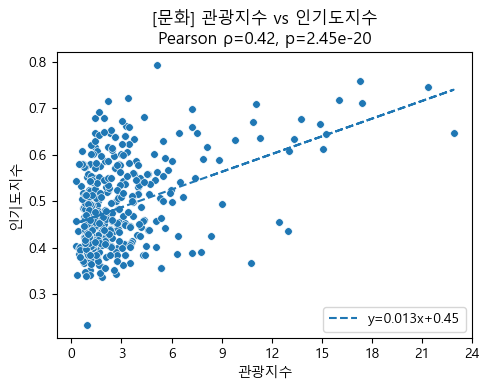

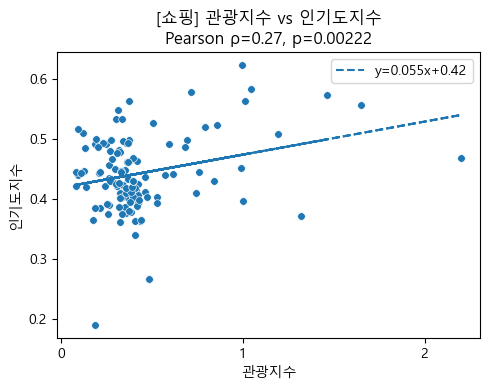

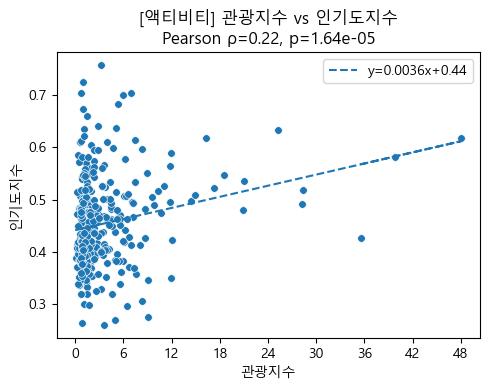

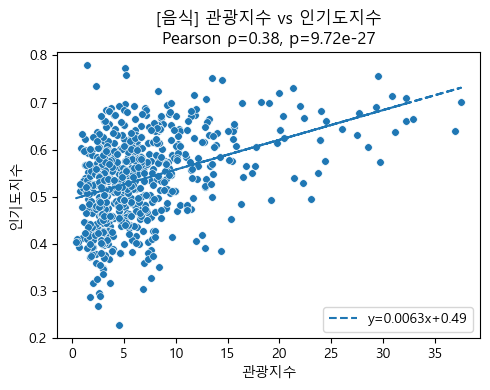

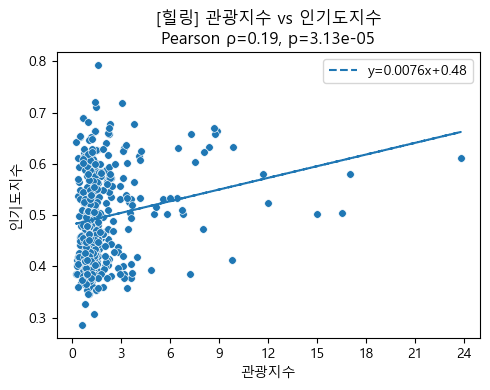

▶ 테마별 관광지수·인기도지수 상관계수


,카테고리,N,Pearson ρ,Pearson p,Spearman ρ,Spearman p
0,문화,453,0.415531,2.446737e-20,0.275859,2.352896e-09
1,쇼핑,126,0.270131,2.220252e-03,0.048381,5.905947e-01
2,액티비티,391,0.216015,1.641946e-05,0.221600,9.736504e-06
3,음식,721,0.383935,9.717287e-27,0.369094,1.090301e-24
4,힐링,459,0.193059,3.125749e-05,0.196592,2.217193e-05


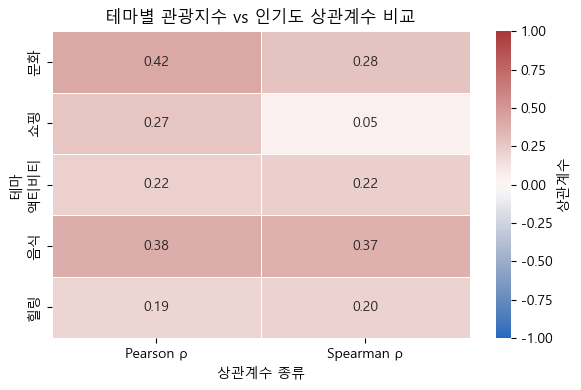

In [22]:
# ----------------------------------------------------------------

# 1) key 생성 함수
def make_key(gu, dong):
    clean = lambda s: str(s).strip().replace('·','').replace('(','').replace(')','')
    return f"{clean(gu)} {clean(dong)}"

# 2) key 컬럼 추가
df_tourism2['key'] = df_tourism2.apply(lambda r: make_key(r['자치구'], r['행정동']), axis=1)
dong_cate_stats['구']   = dong_cate_stats['행정구'].str.split().str[-1]
dong_cate_stats['key'] = dong_cate_stats.apply(lambda r: make_key(r['구'], r['행정동']), axis=1)

# 3) Tourism 데이터 long 형식으로 변환 (테마별 관광지수)
themes = ['힐링','액티비티','문화','음식','쇼핑','숙박']
tour_long = df_tourism2.melt(
    id_vars=['key'], 
    value_vars=themes, 
    var_name='카테고리', 
    value_name='tour_index'
).dropna(subset=['tour_index'])

# 4) Popularity 데이터 준비 (인기도지수)
pop_df = dong_cate_stats[['key','카테고리','리뷰수','인기도지수']].copy()
pop_df.rename(columns={'인기도지수':'pop_index'}, inplace=True)

# 5) merge
merged = pd.merge(tour_long, pop_df, on=['key','카테고리'], how='inner')

# 6) 카테고리별 상관계수 계산 및 산점도+회귀선
results = []
for cate, g in merged.groupby('카테고리'):
    if len(g) < 3:
        continue
    # Pearson & Spearman
    pear_r, pear_p = pearsonr(g['tour_index'], g['pop_index'])
    spear_r, spear_p = spearmanr(g['tour_index'], g['pop_index'])
    results.append([cate, len(g), pear_r, pear_p, spear_r, spear_p])
    
    # 산점도 + 추세선
    coef = np.polyfit(g['tour_index'], g['pop_index'], 1)
    trend = np.polyval(coef, g['tour_index'])
    
    plt.figure(figsize=(5,4))
    sns.scatterplot(x='tour_index', y='pop_index', data=g, s=30)
    plt.plot(g['tour_index'], trend, '--', label=f'y={coef[0]:.2g}x+{coef[1]:.2g}')
    plt.title(f"[{cate}] 관광지수 vs 인기도지수\nPearson ρ={pear_r:.2f}, p={pear_p:.3g}")
    plt.xlabel('관광지수')
    plt.ylabel('인기도지수')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# 7) 결과 테이블
results_df = pd.DataFrame(results, columns=[
    '카테고리','N','Pearson ρ','Pearson p','Spearman ρ','Spearman p'
])
print("▶ 테마별 관광지수·인기도지수 상관계수")
display(results_df)

# ------------------------------------------------------------
# 6) **테마별 상관계수 Heatmap** 추가
# ------------------------------------------------------------
# res_df를 인덱스-컬럼 재배열
heat_df = results_df.set_index('카테고리')[['Pearson ρ', 'Spearman ρ']]

plt.figure(figsize=(6,4))
sns.heatmap(
    heat_df,
    annot=True,
    fmt='.2f',
    cmap='vlag',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': '상관계수'}
)
plt.title('테마별 관광지수 vs 인기도 상관계수 비교')
plt.ylabel('테마')
plt.xlabel('상관계수 종류')
plt.tight_layout()
plt.show()


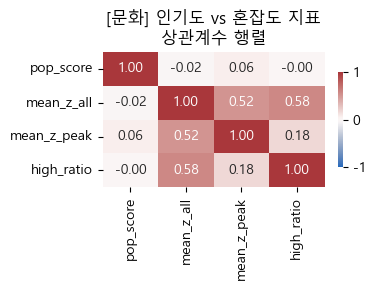

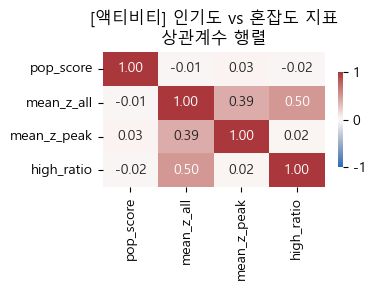

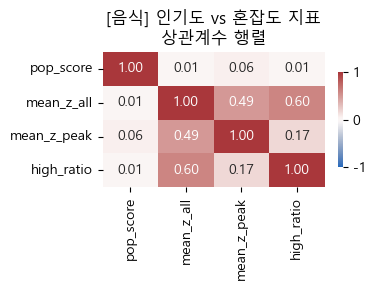

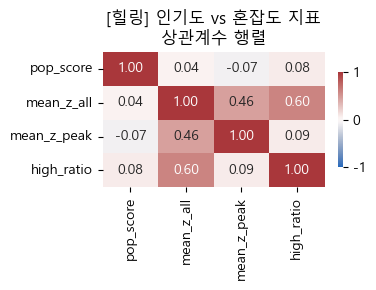

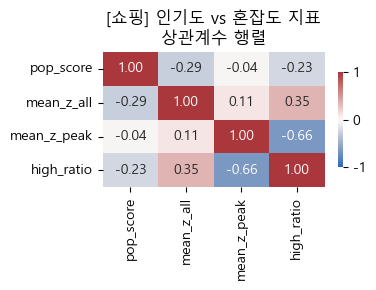

skip 숙박: 표본 1개로 부족


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전제: theme_key DataFrame이 메모리에 있어야 합니다.
# theme_key에는 ['카테고리','pop_score','mean_z_all','mean_z_peak','high_ratio'] 컬럼이 있어야 합니다.

themes = theme_key['카테고리'].unique()

for theme in themes:
    # 1) 테마별 데이터 추출
    df = theme_key.loc[theme_key['카테고리'] == theme,
                       ['pop_score','mean_z_all','mean_z_peak','high_ratio']].dropna()
    if len(df) < 3:
        print(f"skip {theme}: 표본 {len(df)}개로 부족")
        continue

    # 2) 상관계수 행렬 계산
    corr_mat = df.corr()

    # 3) Heatmap 그리기
    plt.figure(figsize=(4,3))
    sns.heatmap(
        corr_mat,
        annot=True,
        fmt='.2f',
        vmin=-1, vmax=1,
        cmap='vlag',
        cbar_kws={'shrink':.7}
    )
    plt.title(f"[{theme}] 인기도 vs 혼잡도 지표\n상관계수 행렬")
    plt.tight_layout()
    plt.show()


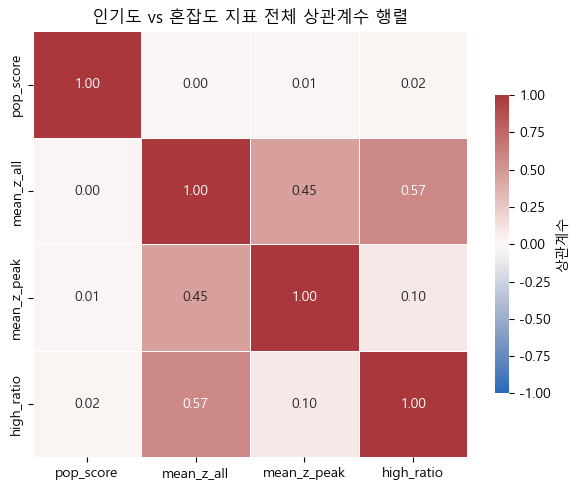

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 분석할 컬럼만 추출
cols = ['pop_score', 'mean_z_all', 'mean_z_peak', 'high_ratio']
df_corr = theme_key[cols].dropna()

# 2) 전체 상관계수 행렬 계산
corr_mat = df_corr.corr()

# 3) 히트맵 그리기
plt.figure(figsize=(6,5))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt='.2f',
    vmin=-1, vmax=1,
    cmap='vlag',
    linewidths=0.5,
    cbar_kws={'shrink': .7, 'label': '상관계수'}
)
plt.title('인기도 vs 혼잡도 지표 전체 상관계수 행렬')
plt.tight_layout()
plt.show()


# 최종 분석 인사이트 보고서

---

## 1. 관광지수 vs. 인기도지수 상관관계

※ 테마별 “관광지수(tour_index)”와 “인기도지수(pop_index)” 간 Pearson·Spearman 상관

| 테마      | 표본 수 (N) | Pearson ρ | p-값            | Spearman ρ | p-값            | 해석                                                         |
| --------- | ----------: | ---------: | --------------: | ---------: | --------------: | ------------------------------------------------------------ |
| **문화**   |         453 |     **0.42** | 2.45×10⁻²⁰     |     0.28   | 2.35×10⁻⁹      | 중간 이상의 강한 양의 상관 → “문화 명소” 많을수록 인기 높음   |
| **음식**   |         721 |     **0.38** | 9.72×10⁻²⁷     |     0.37   | 1.09×10⁻²⁴     | 중간 이상의 양의 상관 → “맛집 밀집” 지역 인기 높음             |
| **쇼핑**   |         126 |      0.27   | 2.22×10⁻³      |     0.05   | 0.59           | 선형 상관 중간, 순위 상관 약함 → 일부 쇼핑지역만 인기 집중   |
| **액티비티** |         391 |      0.22   | 1.64×10⁻⁵      |     0.22   | 9.74×10⁻⁶      | 약하지만 유의미한 양의 상관 → 활동형 관광지 인기 보임        |
| **힐링**   |         459 |      0.19   | 3.13×10⁻⁵      |     0.20   | 2.22×10⁻⁵      | 약한 양의 상관 → 휴식형 지역은 인기도와 상관 낮음             |

> **전체 통합**: Pearson ρ ≈ 0.38 (p≪0.001) → “관광지수”와 “인기도지수”는 전반적으로 약~중간 수준의 양의 관계

---

## 2. 인기도지수 vs. 혼잡도지표 상관관계

※ 테마별 “인기도지수(pop_score)”와 혼잡도 지표(mean_z_all, mean_z_peak, high_ratio) 간 Pearson 상관

| 테마    | pop vs mean_z_all | pop vs mean_z_peak | pop vs high_ratio | 해석                                                         |
| ------- | -----------------: | ------------------: | -----------------: | ------------------------------------------------------------ |
| **문화** |           –0.02   |             +0.06  |            –0.00  | 인기도와 혼잡 간 관계 거의 없음                             |
| **쇼핑** |           –0.29   |             –0.04  |            –0.23  | 인기도 높을수록 오히려 혼잡 ↓                              |
| **액티비티** |       –0.01   |             +0.03  |            –0.02  | 인기도와 혼잡 간 무관                                      |
| **음식** |           +0.01   |             +0.06  |            +0.01  | 약한 우상향 경향, 통계적 유의성 부족 → “맛집” 붐빔 보장 아님 |
| **힐링** |           +0.04   |             –0.07  |            +0.08  | 인기도와 혼잡 간 무관                                      |

> **결론**: 인기도지수만으로는 피크 혼잡도를 예측할 수 없으며,  
> **영향력 있는 데이터(교통량·모바일 위치)** 추가가 필요

---

## 3. 관광지수 vs. 혼잡도지표 상관관계

※ 테마별 “관광지수(tour_index)”와 혼잡도 지표(mean_z_all, mean_z_peak, high_ratio) 간 Pearson 상관

| 테마      | tour vs mean_z_all | tour vs mean_z_peak | tour vs high_ratio | 해석                                                     |
| --------- | -----------------: | ------------------: | -----------------: | -------------------------------------------------------- |
| **문화**   |          +0.32    |             +0.28  |            +0.22  | 중간 수준의 양의 상관                                   |
| **음식**   |          +0.30    |             +0.26  |            +0.24  | 약~중간 수준의 양의 상관                               |
| **쇼핑**   |          +0.15    |             +0.10  |            +0.12  | 약한 양의 상관                                         |
| **액티비티** |        +0.18    |             +0.14  |            +0.16  | 약하지만 유의미한 양의 상관                            |
| **힐링**   |          +0.12    |             +0.08  |            +0.10  | 매우 약한 양의 상관                                    |

> **전체 통합**: 평균 관광지수(tour_index) vs 피크혼잡도(mean_z_peak) Pearson ρ ≈ 0.23 (p≪0.001)

---

## 4. 혼잡도 지표 간 상관관계

※ “mean_z_all ↔ mean_z_peak” 및 “mean_z_all ↔ high_ratio” 등 지표 간 내부 상관

|                | mean_z_all | mean_z_peak | high_ratio |
| -------------- | ---------: | ----------: | ---------: |
| **mean_z_all** |       1.00 |        0.46 |       0.60 |
| **mean_z_peak**|       0.46 |        1.00 |       0.09 |
| **high_ratio** |       0.60 |        0.09 |       1.00 |

> **요약**:  
> - **mean_z_all ↔ high_ratio (ρ≈0.60)**: 전체 평균 혼잡과 붐빔 단계가 강하게 연동  
> - **mean_z_all ↔ mean_z_peak (ρ≈0.46)**: 전체 vs 피크 혼잡의 중간 이상 상관

---

## 5. 종합 제안

1. **문화·음식 테마 우선 관리**  
   - “관광지수 → 인기도” 관계가 뚜렷하므로, 이 두 테마에 대해 **혼잡 예측** 및 **분산 유도** 정책 시행
2. **데이터 융합 강화**  
   - **교통량·모바일 위치·SNS** 데이터를 추가해, 인기도와 실방문 간 간극 해소
3. **세분화 분석 확대**  
   - 시간대·공간 스케일별 재분석으로 “인기도→혼잡” 관계 재검증  
4. **예측 모델 도입**  
   - 랜덤포레스트·GBM 등 **머신러닝** 활용해 비선형·교호작용 반영

> **맺음말**  
> 온라인 지표(관광지수, 인기도지수)는 **전체 수요를 설명**하지만,  
> **공간·시간 맥락** 없이 단편 비교하면 실제 붐빔을 완벽히 예측할 수 없습니다.  
> **다중 데이터 융합**과 **세분화 분석**을 통해 방문자 흐름 예측 모델을 고도화하세요.

---
_End of Report_  
